<a href="https://colab.research.google.com/github/JALVITO/CE888/blob/master/Labs/Lab_8/Lab_8_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.xception import preprocess_input

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/8voSemestre/CE888/Labs/lab8-data

/content/drive/MyDrive/8voSemestre/CE888/Labs/lab8-data


In [4]:
DIM = 299
LR = 1e-4

In [5]:
print('Loading training data...')
train_data = image_dataset_from_directory('train',
                                          label_mode='categorical',
                                          image_size=(DIM, DIM),
                                          seed=42,
                                          validation_split=0.2,
                                          subset="training")

print('\nLoading validation data...')
val_data = image_dataset_from_directory('train',
                                        label_mode='categorical',
                                        image_size=(DIM, DIM),
                                        seed=42,
                                        validation_split=0.2,
                                        subset="validation")

print('\nLoading test data...')
test_data = image_dataset_from_directory('test', 
                                         label_mode='categorical',
                                         image_size=(DIM, DIM))

Loading training data...
Found 648 files belonging to 4 classes.
Using 519 files for training.

Loading validation data...
Found 648 files belonging to 4 classes.
Using 129 files for validation.

Loading test data...
Found 160 files belonging to 4 classes.


In [6]:
input = Input(shape=(DIM, DIM, 3))
preprocess = preprocess_input(input)
base = Xception(input_tensor=preprocess, include_top=True)
base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 299, 299, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         tf.math.subtract[0][0]           
___________________________________________________________________________________________

In [7]:
last = base.get_layer('avg_pool').output
output = Dense(4, activation='softmax', name='output')(last)
model = Model(input, output)

for layer in base.layers:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract (TFOpLambda)   (None, 299, 299, 3)  0           tf.math.truediv[0][0]            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         tf.math.subtract[0][0]           
______________________________________________________________________________________________

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [9]:
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='xception_fe_model.h5', save_best_only=True),
]

history = model.fit(train_data,
                    batch_size=10,
                    epochs=10, 
                    validation_data=val_data,
                    callbacks=my_callbacks)

Epoch 1/10
17/17 [==============================] - 21s 826ms/step - loss: 1.1897 - acc: 0.5515 - val_loss: 0.5442 - val_acc: 0.9380
Epoch 2/10
17/17 [==============================] - 13s 699ms/step - loss: 0.4612 - acc: 0.9501 - val_loss: 0.2888 - val_acc: 0.9457
Epoch 3/10
17/17 [==============================] - 13s 694ms/step - loss: 0.2294 - acc: 0.9771 - val_loss: 0.2098 - val_acc: 0.9612
Epoch 4/10
17/17 [==============================] - 13s 694ms/step - loss: 0.1627 - acc: 0.9893 - val_loss: 0.1712 - val_acc: 0.9690
Epoch 5/10
17/17 [==============================] - 13s 698ms/step - loss: 0.1216 - acc: 0.9882 - val_loss: 0.1472 - val_acc: 0.9845
Epoch 6/10
17/17 [==============================] - 13s 695ms/step - loss: 0.1162 - acc: 0.9855 - val_loss: 0.1324 - val_acc: 0.9767
Epoch 7/10
17/17 [==============================] - 13s 700ms/step - loss: 0.0907 - acc: 0.9950 - val_loss: 0.1172 - val_acc: 0.9845
Epoch 8/10
17/17 [==============================] - 13s 696ms/step - 

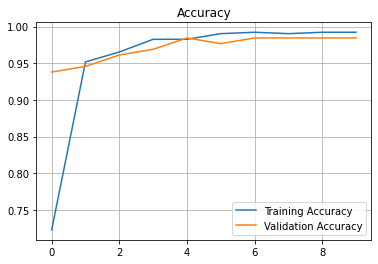

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [11]:
y_pred = np.array([])
y_true =  np.array([])

for x, y in test_data:
  y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)])
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

test_acc = accuracy_score(y_pred, y_true)


print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print()
print(classification_report(y_pred, y_true))

Train Accuracy:	 0.9922928810119629
Val Accuracy:	 0.9844961166381836
Test Accuracy:	 0.98125

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        39
         1.0       1.00      0.98      0.99        41
         2.0       1.00      0.95      0.98        42
         3.0       0.95      1.00      0.97        38

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

